In [1]:
from pathlib import Path
from anomalib.data.utils import read_image
from anomalib.deploy import TorchInferencer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from anomalib.data.folder import Folder
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

### Additionally I modified the data in the following ways:
- I moved all the normal and abnomral instances into their own directories all together,
- I also removed any images with \*ref|Ref\* in their name that were in the abnormal/anomalous directories from being since they are from the refrence image, meaning they are what the client wants. You can verify this for yourselfes.
- To start you might also want to remove the images that are masked initially if you are only running this file, expect updates soon...

In [2]:
from anomalib.data.task_type import TaskType

# data_dir = Path.cwd()
data_dir=Path.cwd()/"Reels"
# print(data_dir)

data_module = Folder(
    root=data_dir,
    normal_dir="normal",
    abnormal_dir="abnormal",
    normal_split_ratio=0.1,
    image_size=(256, 256),
    train_batch_size=64,
    eval_batch_size=64,
    task=TaskType.CLASSIFICATION,
    normalization="imagenet",
    seed=44,
)
data_module.setup()
data_module.prepare_data()
i, data = next(enumerate(data_module.val_dataloader()))
print(data.keys())
print(type(data["image"]))
print(len(data_module.test_data), len(data_module.train_data), len(data_module.val_data))
data_module.train_data[0]

dict_keys(['image_path', 'label', 'image'])
<class 'torch.Tensor'>
179 988 178


{'image_path': '/home/turbouser44/juicebox/Reels/normal/67_0-10.bmp',
 'label': 0,
 'image': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.2147, 2.2318],
          [2.2318, 2.2147, 2.1975,  ..., 2.1633, 2.1633, 2.1633],
          [2.2147, 2.1804, 2.1462,  ..., 2.1290, 2.1119, 2.1119]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.3585, 2.3761, 2.4111,  ..., 2.4286, 2.4286, 2.4286],
          [2.3585, 2.3585, 2.3585,  ..., 2.3936, 2.3936, 2.3936],
          [2.3761, 2.3585, 2.3060,  ..., 2.3761, 2.3761, 2.3761]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6

In [3]:
print(data["image"].shape)

torch.Size([64, 3, 256, 256])


In [4]:
from anomalib.models import Padim

model = Padim(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3", "layer4"]
)

FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [5]:
from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.utils.callbacks import (
    MetricsConfigurationCallback,
    MinMaxNormalizationCallback,
    PostProcessingConfigurationCallback,
)
from anomalib.utils.callbacks.export import ExportCallback, ExportMode

callbacks = [
    MetricsConfigurationCallback(
        task=TaskType.CLASSIFICATION,
        image_metrics=["AUROC"],
    ),
    ModelCheckpoint(
        every_n_epochs=10,
        monitor="image_AUROC",
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    MinMaxNormalizationCallback(),
    ExportCallback(
        input_size=(256, 256),
        dirpath=str(Path.cwd()),
        filename="4layer_model.pt",
        export_mode=ExportMode.TORCH,
    ),
]

In [6]:
trainer = Trainer(num_sanity_val_steps=0, resume_from_checkpoint="./lightning_logs/version_13/checkpoints/epoch=3-step=128.ckpt",callbacks=callbacks, accelerator="auto").fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at ./lightning_logs/version_13/checkpoints/epoch=3-step=128.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PadimModel               | 11.2 M
3 | image_metrics 

Training: 32it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

: 

In [ ]:
# trainer = Trainer(
#     callbacks=callbacks,
#     accelerator="auto",
#     auto_scale_batch_size=False,
#     num_sanity_val_steps=0,
#     check_val_every_n_epoch=4,
#     devices=1,
#     gpus=None,
#     max_epochs=20,
#     num_sanity_val_steps=0,
#     val_check_interval=1.0,
# )
# trainer.fit(model=model, datamodule=data_module)

In [ ]:
test_results = trainer.test(model=model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.7121848464012146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


(166, 166, 3)

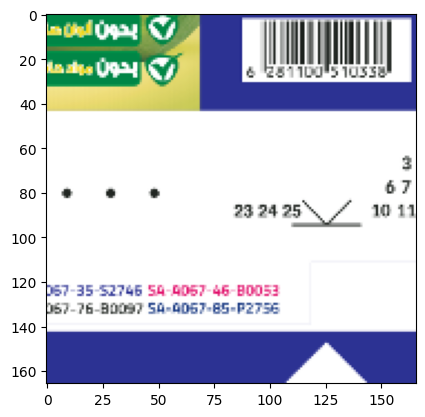

In [ ]:
# trainer= Trainer(resume_from_checkpoint="lightning_logs/version_9/checkpoints/epoch=39-step=1199.ckpt")
from matplotlib import pyplot as plt
norm_imagepath = data_dir/"normal/NpdfSpot_24_ref.bmp"
norm_image = read_image(norm_imagepath)
plt.imshow(norm_image)
norm_image.shape

### Loading the saved model

In [ ]:
# import torch
# model = model.load_from_checkpoint(Path.cwd() / 'lightning_logs/version_6/checkpoints/epoch=3-step=36.ckpt')
# model.laod_sta
model_path = Path.cwd() / 'weights/torch/model.pt'
inferencer = TorchInferencer(path=model_path)

In [ ]:
from pytorch_lightning import LightningModule
import torch
model = torch.load(Path.cwd() / 'lightning_logs/version_25/checkpoints/epoch=9-step=224.ckpt')
# model = LightningModule.load_from_checkpoint(Path.cwd() / 'lightning_logs/version_25/checkpoints/epoch=9-step=224.ckpt')

In [ ]:
model['state_dict']

OrderedDict([('image_threshold.value', tensor(16.0768)),
             ('pixel_threshold.value', tensor(16.0768)),
             ('model.idx',
              tensor([ 72, 118, 423, 693, 505, 345, 247, 252, 715, 862, 717, 873, 254, 528,
                       39, 831, 830, 140, 833, 238, 794, 250, 377, 592, 550, 616, 953,  34,
                      639, 440, 849, 767, 595, 400, 271, 279, 144, 575,  75, 587, 931, 272,
                       37, 880, 210, 891, 696, 673, 628, 786, 874, 466, 274, 641, 428,  59,
                      877, 546, 584, 944, 921, 671, 393, 216, 177, 571, 472, 103, 324, 452,
                      559, 938, 117, 450, 765, 828,   1, 757, 856, 697, 843, 814, 295, 566,
                      507, 744,  12,  14, 785, 845, 130, 955, 333, 896, 564, 122, 161, 454,
                      651, 370], device='cuda:0')),
             ('model.feature_extractor.feature_extractor.conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
        

In [ ]:
#! Predict -> returns ImageResult type
norm_predictions = inferencer.predict(image=norm_image)
# type(predictions)
# predictions
# predictions2 = inferencer.predict(norm_image=abnormal_image)

In [ ]:
from anomalib.post_processing import Visualizer, VisualizationMode
from PIL import Image

# visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
# output_image = visualizer.visualize_image(norm_predictions)
# Image.fromarray(output_image)
# output_image.shape

In [ ]:
from utils import split_into_patches, normalize_patches
# import anomalib.data.utils.transform as tf

visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
# pred_abnormal = inferencer.predict(image=abnormal_image)
abnormal_job_path = data_dir / 'Job1.bmp'
# print(abnormal_job_path)
abnormal_job_image_patchnormed = read_image(abnormal_job_path)
# print(type(abnormal_job_image_patchnormed))
abnormal_job_image_patchnormed = split_into_patches(abnormal_job_image_patchnormed)
# abnormal_job_image_patchnormed = normalize_patches(abnormal_job_image_patchnormed)


In [ ]:
# print(type(normd_abnormal_job_image_patched[0]))
print(type(abnormal_job_image_patchnormed))
# h = read_image(normd_abnormal_job_image_patched)
# visualizer.visualize_image(norm_abnormal_job_image_patched)
# print(h.shape)
# (normd_abnormal_job_image_patched)
preds_full_print_job = []
i=0
for i in range(len(abnormal_job_image_patchnormed)):
    # abnormal_job_image_patchnormed[i] = normalize_patches(abnormal_job_image_patchnormed[i])
    preds_full_print_job.append(inferencer.predict(image=abnormal_job_image_patchnormed[i]))
    Image.fromarray(visualizer.visualize_image(preds_full_print_job[i])).save(f"printjob_patch_prediction{i}.png")
    break
    # Image.fromarray(visualizer.visualize_image(preds_full_print_job[i])).save(f"./lightning_logs/tmp_imgs/Job1_Path{i}.png")
    # Image.fromarray(visualizer.visualize_image(predsJob))
    # h = read_image(abnormal_job_image_patchnormed)

    # break
    # out_im_batch_job = visualizer.visualize_image(h)
    # if i ==40:
    #     break
# output_image = visualizer.visualize_image(normd_abnormal_job_image_patched[180])
# Image.fromarray(output_image)
# type(abnormal_job_image_patchnormed)


<class 'numpy.ndarray'>


In [ ]:
from inference import infer
# inferencer
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
unseen_anomalous_preds = infer("./Reels/heldoutAnomalous")
for i in range(len(unseen_anomalous_preds)):
    Image.fromarray(visualizer.visualize_image(unseen_anomalous_preds[i])).save(f"unseen_anomalous{i}.png")
    # break

In [ ]:
# Creating more data out of refrence images and adding it to the normal images dataset
# from utils import split_into_patches, normalize_patches
# # abnormal_job_path = data_dir / 'Job1.bmp'

# # abnormal_job_image_patchnormed = read_image(abnormal_job_path)
# # abnormal_job_image_patchnormed = split_into_patches(abnormal_job_image_patchnormed)

# import os
# for _, _, f in os.walk(data_dir/"refs"):
#     print(f[0])
#     img = read_image(os.path.join(data_dir/"refs", f[0]))
#     img = split_into_patches(img)
#     for i in range(len(img)):
#         Image.fromarray(img[i]).save(data_dir/f"normal/NSynthetic_{i}.jpg")
#     print(len(f))